# View files

Now that we have the raw images and the raw labels, we can start viewing each file to see whether they look correct or additional data is needed. To view these files, we will use napari and torchio and some other dependencies which we will load in below.

In [1]:
import napari
import torchio as tio
import os
from pathlib import Path
import numpy as np
import pandas as pd

img_dir = './dataset/images/'
label_dir = './dataset/labels/'

info = pd.read_csv('raw_image_info.csv')

Let's display what info we have available in our csv file

In [5]:
info

,image_file_path,raw_annotated_file_path,status,swap_xy,flip_y,check,old_swap_xy,old_flip_y,OLD check,has correct spacing,needs_cropping_after_creation,other notes
0,dataset/images/diurnal_tarsata.nii,//home/jake/projects/mctv_resfiles/ants/diurna...,good,False,False,NaN,False,False,good,FALSE,False,data with incorrect spacing have irregular siz...
1,dataset/images/dampieri_20151218.nii,//home/jake/projects/mctv_resfiles/fiddlercrab...,good,False,False,NaN,False,False,good,FALSE,False,NaN
2,dataset/images/dampieri_20200218_male_left_167...,//home/jake/projects/mctv_resfiles/fiddlercrab...,good,False,False,NaN,False,False,good (possibly hard to see missing ones at edges),FALSE,False,NaN
3,dataset/images/dampieri_male_16.nii,//home/jake/projects/mctv_resfiles/fiddlercrab...,good but crop,False,False,NaN,False,False,needs cropping,FALSE,True,NaN
4,dataset/images/flammula_20180307.nii,//home/jake/projects/mctv_resfiles/fiddlercrab...,good,False,False,NaN,False,False,good,FALSE,False,NaN
5,dataset/images/flammula_20190925_male_left.nii,//home/jake/projects/mctv_resfiles/fiddlercrab...,good but crop,False,False,NaN,False,False,needs cropping,FALSE,True,NaN
6,dataset/images/flammula_20200327_female_left_1...,//home/jake/projects/mctv_resfiles/fiddlercrab...,good but crop,False,False,NaN,False,False,needs cropping,FALSE,True,NaN
7,dataset/images/neohelice_20190616_1_cropped.nii,//home/jake/projects/mctv_resfiles/fiddlercrab...,good but crop,False,False,NaN,False,False,needs cropping,FALSE,True,NaN
8,dataset/images/Hyperia_02_head_FEG190604_014C,//home/jake/projects/mctv_resfiles/hyperiids/h...,good but crop,False,False,NaN,False,False,wrong orientation or image,FALSE,False,NaN
9,dataset/images/Hyperia_01_head_FEG190604_014B,//home/jake/projects/mctv_resfiles/hyperiids/h...,good,False,False,NaN,False,False,good,FALSE,False,NaN


I can see that we have the paths to our images (they are either nifti files or dicom directories). These should be easy to calculate with the following:

In [13]:
images = info.image_file_path
images[:10]

0                   dataset/images/diurnal_tarsata.nii
1                 dataset/images/dampieri_20151218.nii
2    dataset/images/dampieri_20200218_male_left_167...
3                  dataset/images/dampieri_male_16.nii
4                 dataset/images/flammula_20180307.nii
5       dataset/images/flammula_20190925_male_left.nii
6    dataset/images/flammula_20200327_female_left_1...
7      dataset/images/neohelice_20190616_1_cropped.nii
8        dataset/images/Hyperia_02_head_FEG190604_014C
9        dataset/images/Hyperia_01_head_FEG190604_014B
Name: image_file_path, dtype: object

In [16]:
print(f'Found {len(labels)} labelled images for analysis')

Found 38 labelled images for analysis


These files are huge, so we need to use nibabel proxy slicing to collect only the data we need for the plot.
Let's prepare by making some nice functions that can load all our images, get the slices we need and plot them.

In [37]:
import matplotlib.pyplot as plt
import nibabel as nib
import math

def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices))
   fig.set_size_inches(18.5, 10.5)
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")
        
def load_and_plot(name, return_array=False):
    """ Load x y and z middle slices of volume and plot efficiently, using nibabel proxy slicing """
    proxy_img = nib.load(name)
    img_shape = proxy_img.shape
    vol1 = proxy_img.dataobj[math.floor(img_shape[0]/2), :, :]
    vol2 = proxy_img.dataobj[:, math.floor(img_shape[1]/2), :]
    vol3 = proxy_img.dataobj[:, :, math.floor(img_shape[2]/2)]
    array = [
        vol1,
        vol2,
        vol3
    ]   
    show_slices(array)
    if return_array:
        return array
    
def load_and_plot_pair(name1, name2, index=0, axis=2, return_array=False):
    """
    Load single axis slice of two volumes and plot efficiently, using nibabel proxy slicing.
    Note, z axis (axis 2) will plot the fastest due to the way proxy slicing works
    
    """
    proxy_img1 = nib.load(name1)
    proxy_img2 = nib.load(name2)
    if axis == 0:
        vol1 = proxy_img1.dataobj[index, ...] 
        vol2 = proxy_img2.dataobj[index, ...]
    if axis == 1:
        vol1 = proxy_img1.dataobj[:, index, :] 
        vol2 = proxy_img2.dataobj[:, index, :]
    if axis == 2:
        vol1 = proxy_img1.dataobj[..., index] 
        vol2 = proxy_img2.dataobj[..., index]
    array = [
        vol1,
        vol2
    ]   
    show_slices(array)
    if return_array:
        return array

Now let's go through each scan and make sure the data points match up correctly.

Plotting scan: dataset/images/dampieri_male_16.nii
Unique values in label slice are: [0 1 2]


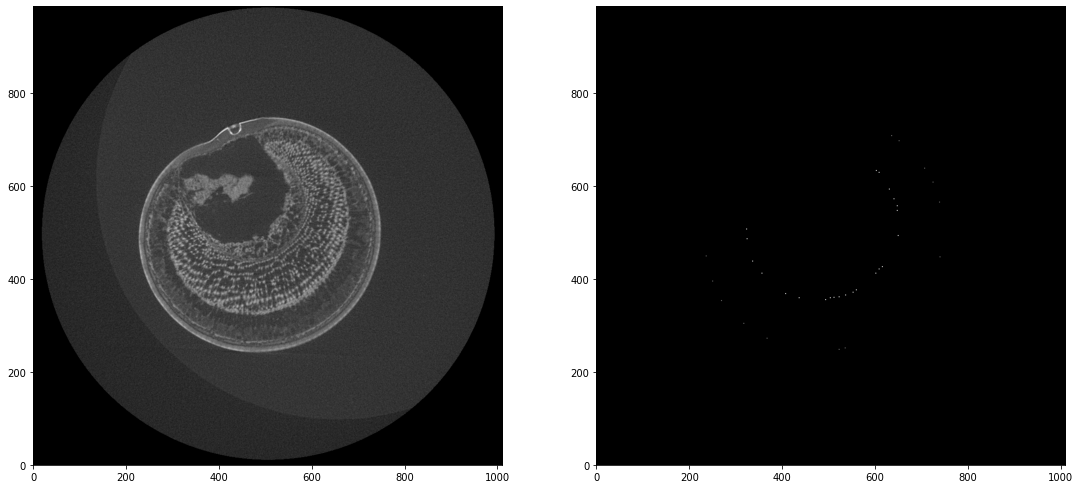

In [44]:
scan = 3
name1 = images[scan]
name2 = labels[scan]

print(f'Plotting scan: {name1}')

array = load_and_plot_pair(name1, name2, index=200, axis=2, return_array = True)
print(f'Unique values in label slice are: {np.unique(array[1])}')